In [10]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import re
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data= pd.read_csv('/kaggle/input/scripts-game/EverythingScripts(1).csv')
fnaf_df= data.loc[data['Game Category']=='fivenightsatfreddys',['Scripts']]
valid_pattern = r'[A-Za-z0-9\[\]{}\'"/<>,.]'
def clean_text(text):
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)  
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    # Convert to lowercase and keep valid characters  
    text = re.sub(valid_pattern, lambda x: x.group().lower(), text)  
    return text
# Clean each row of the 'Scripts' column
fnaf_df['Scripts'] = fnaf_df['Scripts'].apply(clean_text)
# check the number of distinct words
words=[]
for row in fnaf_df['Scripts']:
    row=row.lower()
    tokens = re.findall(r'\w+|[^\w\s]', row)
    words.extend(tokens)
words = sorted(list(set(words)))

stoi = {s:i+1 for i,s in enumerate(words)}
stoi['S/ETOKEN'] = 0
itos = {i:s for s,i in stoi.items()}
number_dist=len(itos)

In [11]:
print(number_dist)

11497


In [12]:
block_size = 3 

def build_dataset(data):
  X, Y = [], []
  for w in data:
    context = [0] * block_size
    w=w.lower()
    tokens = re.findall(r'\w+|[^\w\s]',w)
    tokens.append('S/ETOKEN')
    for items in tokens:
      ix = stoi[items]
      X.append(context)
      Y.append(ix)
      # crop and append
      context = context[1:] + [ix] 
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y
n1 = int(0.8*len(fnaf_df['Scripts']))
n2 = int(0.9*len(fnaf_df['Scripts']))
Xtr, Ytr = build_dataset(fnaf_df['Scripts'][:n1])
Xdev, Ydev = build_dataset(fnaf_df['Scripts'][n1:n2])
Xte, Yte = build_dataset(fnaf_df['Scripts'][n2:])
# making tensor on gpu instead
Xtr, Ytr = Xtr.to(device), Ytr.to(device)
Xdev, Ydev = Xdev.to(device), Ydev.to(device)
Xte, Yte = Xte.to(device), Yte.to(device)

In [13]:


# for reproducibility
g = torch.Generator().manual_seed(2147483647)
# C shape: number of distinct words and len(of what you what the vector of embedding you want) in this case i set it to 600
C = torch.randn((number_dist, 600), generator=g).to(device)
# W1 has to be 600*3 = 1800 since we have block_size = 3, 300 is the number of neuron  
W1 = (torch.randn((1800, 300), generator=g)*(5/3)/1800**0.5).to(device) 
# we introduce Bach norm thus the bias is no longer needed
#b1 = (torch.randn(300, generator=g)*0.01).to(device)
W2 = (torch.randn((300, number_dist), generator=g)*0.01).to(device)
b2 = (torch.randn(number_dist, generator=g)* 0) .to(device)
bngain=(torch.ones((1,300))).to(device)
bnbias=(torch.zeros((1,300))).to(device)
bnmean_running=torch.zeros((1,300)).to(device)
bnstd_running=torch.ones((1,300)).to(device)
parameters = [C, W1, W2, b2, bngain,bnbias] #, b1



In [14]:
# number of parameters in total
sum(p.nelement() for p in parameters)

10899397

In [15]:
for p in parameters:
    p.requires_grad = True
lossi = []
stepi = []
for i in range(200000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,)) 
    # forward pass
    # (64, 3, 600)
    emb = C[Xtr[ix]].to(device)
    # 64 1800  
    embcat=emb.view(emb.shape[0],-1)
    # 64 300
    hpreact=embcat@ W1#+b1
    
    #batch norm layer
    #####
    bnmeani=hpreact.mean(0,keepdim=True)
    bnstdi=hpreact.std(0,keepdim=True)
    hpreact.std(0,keepdim=True)
    hpreact=bngain * (hpreact-bnmeani)/bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running=0.999*bnmean_running+0.001*bnmeani
        bnstd_running=0.999*bnstd_running+0.001*bnstdi
    #####
    
    # 64 300
    h= torch.tanh(hpreact)
    # 64 300 @ 300 num_dist = 64 num dist
    logits = (h @ W2 + b2).to(device) 
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update This can be played with
    if i < 34000:
        lr = 0.56 
    if 34000<i< 48000:
        lr=0.1
    if i>48000:
        lr=0.001
    for p in parameters:
        p.data += -lr * p.grad
    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item()) 
    if i % 10000 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")


Iteration 0, Loss: 9.356344223022461
Iteration 10000, Loss: 5.728572845458984
Iteration 20000, Loss: 4.6281046867370605
Iteration 30000, Loss: 4.018469333648682
Iteration 40000, Loss: 3.178049087524414
Iteration 50000, Loss: 2.981070041656494
Iteration 60000, Loss: 2.851372241973877
Iteration 70000, Loss: 4.258028984069824
Iteration 80000, Loss: 3.5395679473876953
Iteration 90000, Loss: 3.066586494445801
Iteration 100000, Loss: 3.2323367595672607
Iteration 110000, Loss: 2.7484116554260254
Iteration 120000, Loss: 2.9738118648529053
Iteration 130000, Loss: 4.212815761566162
Iteration 140000, Loss: 2.3721771240234375
Iteration 150000, Loss: 2.730097532272339
Iteration 160000, Loss: 3.1475841999053955
Iteration 170000, Loss: 2.5469655990600586
Iteration 180000, Loss: 2.7399587631225586
Iteration 190000, Loss: 2.745851516723633


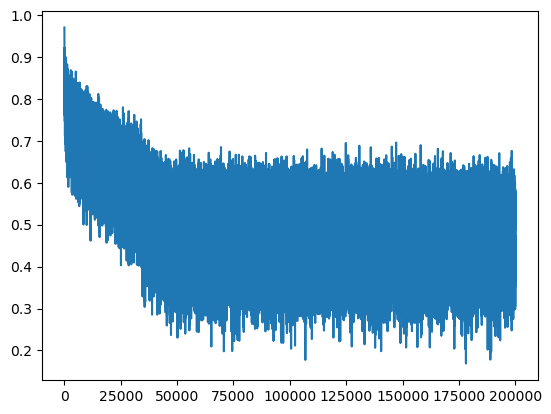

In [16]:
plt.plot(stepi, lossi)

In [17]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    batch_size = 32
    num_batches = len(x) // batch_size
    loss_total = 0
    for i in range(num_batches):
        x_batch = x[i * batch_size: (i + 1) * batch_size]
        y_batch = y[i * batch_size: (i + 1) * batch_size]
        emb = C[x_batch]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, y_batch)
        loss_total += loss
        torch.cuda.empty_cache()  # Release memory
    average_loss = loss_total / num_batches
    print(split, average_loss.item())
split_loss('train')
split_loss('val')

train 2.8870902061462402
val 6.115792274475098


### Overfitting to training set

# Generation of Script

In [20]:
out = []
context = [0] * block_size
while True:
    emb = C[torch.tensor([context])] 
    h = torch.tanh(emb.view(1, -1) @ W1)#  + b1
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
        break
    
print(' '.join(itos[i] for i in out))

[ music ] [ applause ] hello internet welcome welcome more effing throw word child bear ' s pizzaplex playing purple life becoming indulge confirms one feel own bad guys people animatronic murder suit back study school retro gregory released back should probably most watched episodes cameo into custom grid foxy bro make definitely date clear four main thefazbear mobile made clear work : love kids died still an actual deal played same banjo tried kind my challenges half vpn 2023 , wiped filled with searing four arcade games trailer watched death hiding 1 least one final bonus said different loose ends speaking force partnering father fanart he noticed live turn lore solving years found knight speaking going back then drinking to sister location trailer music ) normal matpat re doing fan ! uh children cheering just plush traps steady ) whooaohaahaoaah normal ' s room buried empty house minigame doesn ' t stop for answers kids get taken away by take aura living turn room spirit tells me i